In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [33]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
print(len(data))

9093


# remove missing data

In [3]:
# remove all data for years/countries where one of the 3 variables is entirely missing

country_temp_data = {}
country_precip_data = {}
country_gdp_data = {}

for row in data.iterrows():
    country = row[1].iso
    year = row[1].year
    if country not in country_temp_data:
        country_temp_data[country] = []
    if country not in country_precip_data:
        country_precip_data[country] = []
    if country not in country_gdp_data:
        country_gdp_data[country] = []
    country_temp_data[country].append(row[1].UDel_temp_popweight)
    country_precip_data[country].append(row[1].UDel_precip_popweight)
    country_gdp_data[country].append(row[1].growthWDI)

countries_missing_temp = [country for country in country_temp_data if all(np.isnan(country_temp_data[country]))]
countries_missing_precip = [country for country in country_precip_data if all(np.isnan(country_precip_data[country]))]
countries_missing_gdp = [country for country in country_gdp_data if all(np.isnan(country_gdp_data[country]))]

countries_missing_one_or_more = set(countries_missing_temp + countries_missing_precip + countries_missing_gdp)
countries_missing_all = set(countries_missing_temp).intersection(set(countries_missing_precip)).intersection(set(countries_missing_gdp))

indices_to_drop = []
for index, row in enumerate(data.itertuples()):
    # if row.iso in countries_missing_one_or_more:
    if row.iso in countries_missing_all:
        indices_to_drop.append(index)
    # 1960 data removed because there is no Delta GDP for first year which causes problem in 1960 year effect
    # elif row.year == 1960:
    #     indices_to_drop.append(index)
        
data_len_before = len(data)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(f"Removed {data_len_before - len(data)} rows for completely missing country data.")

Removed 155 rows for completely missing country data.


In [5]:
# optionally remove all rows with any missing value

indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
data_no_missing = data_no_missing.reset_index()
X = np.column_stack((
    data_no_missing.UDel_temp_popweight,
    np.square(data_no_missing.UDel_temp_popweight),
    data_no_missing.UDel_precip_popweight,
    np.square(data_no_missing.UDel_precip_popweight)
))
Y = np.array(data_no_missing.growthWDI).reshape(-1,1)
linreg = LinearRegression().fit(X,Y)
print(linreg.coef_)
print(linreg.intercept_)

[[ 8.38589795e-04 -4.50499041e-05  3.81664518e-06 -3.22334981e-10]]
[0.01702781]


# data scaling

In [75]:
# precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
# precip_scaled = precip_scaler.fit_transform(np.array(data_no_missing.UDel_precip_popweight).reshape(-1,1)).flatten()
# gdp_scaled = gdp_scaler.fit_transform(np.array(data_no_missing.growthWDI).reshape(-1,1)).flatten()
# temp_scaled = temp_scaler.fit_transform(np.array(data_no_missing.UDel_temp_popweight).reshape(-1,1)).flatten()

precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# year and country fixed effect coefficient matrices

In [76]:
# data_len = len(data_no_missing.year)
# year_mult_mat = [np.zeros(data_len) for year in set(data_no_missing.year)]
# country_mult_mat = [np.zeros(data_len) for country in set(data_no_missing.iso)]
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
# for row_index, row in enumerate(data_no_missing.itertuples()):
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - 1960
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1

In [77]:
# gradual year-by-year effects
# grad_effects_data = np.transpose(np.array(data_no_missing.loc[:, data_no_missing.columns.str.startswith(('_y'))]))
grad_effects_data = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_y'))]))

In [78]:
with pm.Model() as model:

    # country_coefs_temp_prior = pt.expand_dims(pm.Normal("country_coefs_temp_prior", 0, 1, shape=(len(set(data.iso)))),axis=1)
    # temp_prior = pm.Deterministic("temp_prior",pt.sum(country_coefs_temp_prior*country_mult_mat,axis=0))
    temp_nan_index = [i for i in range(len(temp_scaled)) if np.isnan(temp_scaled[i])]
    temp_prior = pm.Normal("temp_prior", 0, 1)
    # temp_std = pm.HalfNormal("temp_std", 10)
    # temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=temp_scaled)

    # country_coefs_precip_prior = pt.expand_dims(pm.Normal("country_coefs_precip_prior", 0, 1, shape=(len(set(data.iso)))),axis=1)
    # precip_prior = pm.Deterministic("precip_prior",pt.sum(country_coefs_precip_prior*country_mult_mat,axis=0))
    # precip_prior = pm.Normal("precip_prior", 0, 1)
    # precip_std = pm.HalfNormal("precip_std", 10)
    # precip_posterior = pm.Normal("precip_posterior", precip_prior, precip_std, observed=precip_scaled)

    gdp_intercept = pm.Normal('gdp_intercept',0,10)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,10)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,10)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,10)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,10)

    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 10, shape=(len(set(data.year)))),axis=1)
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_coefs*year_mult_mat,axis=0))

    country_coefs_gdp_fe = pt.expand_dims(pm.Normal("country_coefs_gdp_fe", 0, 10, shape=(len(set(data.iso)))),axis=1)
    country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum(country_coefs_gdp_fe*country_mult_mat,axis=0))

    gradual_effect_coefs = pt.expand_dims(pm.Normal("grad_effect_coefs", 0, 10, shape=(len(grad_effects_data))),axis=1)
    gradual_effects = pm.Deterministic("grad_effects",pt.sum(gradual_effect_coefs*grad_effects_data,axis=0))

    combined = [temp_scaled[i] if not np.isnan(temp_scaled[i]) else temp_prior for i in range(len(temp_scaled))]

    gdp_prior = pm.Deterministic(
        "gdp_prior",
        gdp_intercept +
        # (temp_posterior * temp_gdp_coef) +
        # (temp_gdp_coef * temp_scaled) +
        temp_gdp_coef * combined +
        # (temp_sq_gdp_coef * pt.sqr(temp_posterior)) +
        (temp_sq_gdp_coef * pt.sqr(temp_scaled)) +
        # (precip_posterior * precip_gdp_coef) +
        (precip_gdp_coef * precip_scaled) +
        # (precip_sq_gdp_coef * pt.sqr(precip_posterior)) +
        (precip_sq_gdp_coef * pt.sqr(precip_scaled)) +
        year_fixed_effects +
        country_fixed_effects +
        gradual_effects
    )

    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99, cores=4)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4a33830fa0>>
Traceback (most recent call last):
  File "/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4a33830fa0>>
Traceback (most recent call last):
  File "/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
Keyb

In [29]:
model = pd.read_pickle('../models/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-imputed-deterministic-observed-original-dataset.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]
precip_scaler = model["precip_scaler"]
gdp_scaler = model["gdp_scaler"]
temp_scaler = model["temp_scaler"]

In [37]:
trace.posterior.country_temp_priors

<xarray.DataArray 'country_temp_priors' (chain: 4, draw: 1000,
                                         country_temp_priors_dim_0: 8938)>
array([[[-0.13396667, -0.21107559, -0.13072487, ...,  0.01513329,
          0.13485253,  0.27625554],
        [-0.16128579, -0.20211569, -0.18744409, ...,  0.05358664,
          0.13364874,  0.24095333],
        [-0.16940934, -0.22438033, -0.16398394, ...,  0.04344377,
          0.1386404 ,  0.20031432],
        ...,
        [-0.1246508 , -0.09622105, -0.26420538, ...,  0.02263584,
          0.14251024,  0.10811246],
        [-0.15063534, -0.11781753, -0.28080621, ...,  0.03724206,
          0.16367749,  0.10736825],
        [-0.09876359, -0.09383436, -0.2705742 , ...,  0.0083167 ,
          0.1940486 ,  0.1179338 ]],

       [[-0.10324593, -0.14594732, -0.09191438, ...,  0.2266747 ,
          0.24320426,  0.13205269],
        [-0.10406463, -0.1462536 , -0.09186291, ...,  0.22608151,
          0.25305364,  0.1289362 ],
        [-0.10711171, -0.14489011, -0.09195102, ...,  0.22768012,
          0.24424205,  0.12895491],
...
        [-0.20093723, -0.09300606, -0.08325434, ...,  0.09176754,
          0.09054828,  0.12662868],
        [-0.20418166, -0.09797024, -0.08352206, ...,  0.09120199,
          0.09151574,  0.1237155 ],
        [-0.21219777, -0.09748867, -0.07501613, ...,  0.09956511,
          0.09108427,  0.14517207]],

       [[-0.15590335, -0.11540062, -0.08846104, ...,  0.1592091 ,
         -0.03114361,  0.19812105],
        [-0.14510952, -0.15861023, -0.13419545, ...,  0.12735866,
          0.00227348,  0.15145558],
        [-0.13346324, -0.13813563, -0.14909336, ...,  0.19360782,
          0.03741818,  0.17109716],
        ...,
        [-0.14915215, -0.13102725, -0.0910391 , ...,  0.29981773,
          0.16245702,  0.25531249],
        [-0.1503674 , -0.11265062, -0.10272835, ...,  0.27813246,
          0.14914284,  0.25691083],
        [-0.15204116, -0.11528801, -0.111387  , ...,  0.27645739,
          0.14495339,  0.18521504]]])
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * country_temp_priors_dim_0  (country_temp_priors_dim_0) int64 0 1 ... 8937

AttributeError: 'Axes' object has no attribute 'ravel'

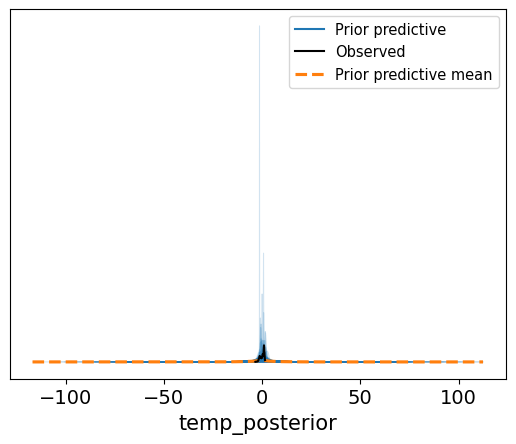

In [34]:
fig = az.plot_ppc(prior,group="prior",var_names=["temp_posterior"]).ravel()[0].figure
fig.show()

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


AttributeError: 'Axes' object has no attribute 'ravel'

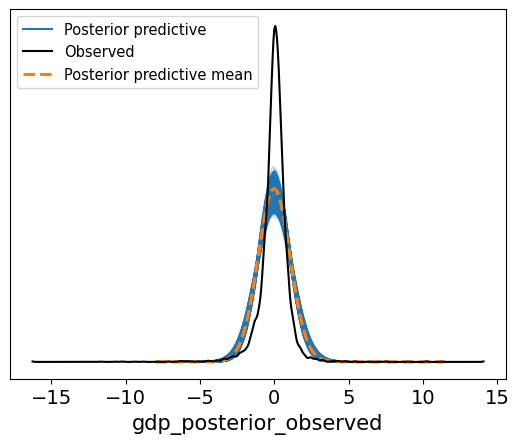

In [19]:
fig = az.plot_ppc(posterior,var_names=["gdp_posterior_observed"]).ravel()[0].figure
fig.show()

/tmp/ipykernel_105125/1883471754.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


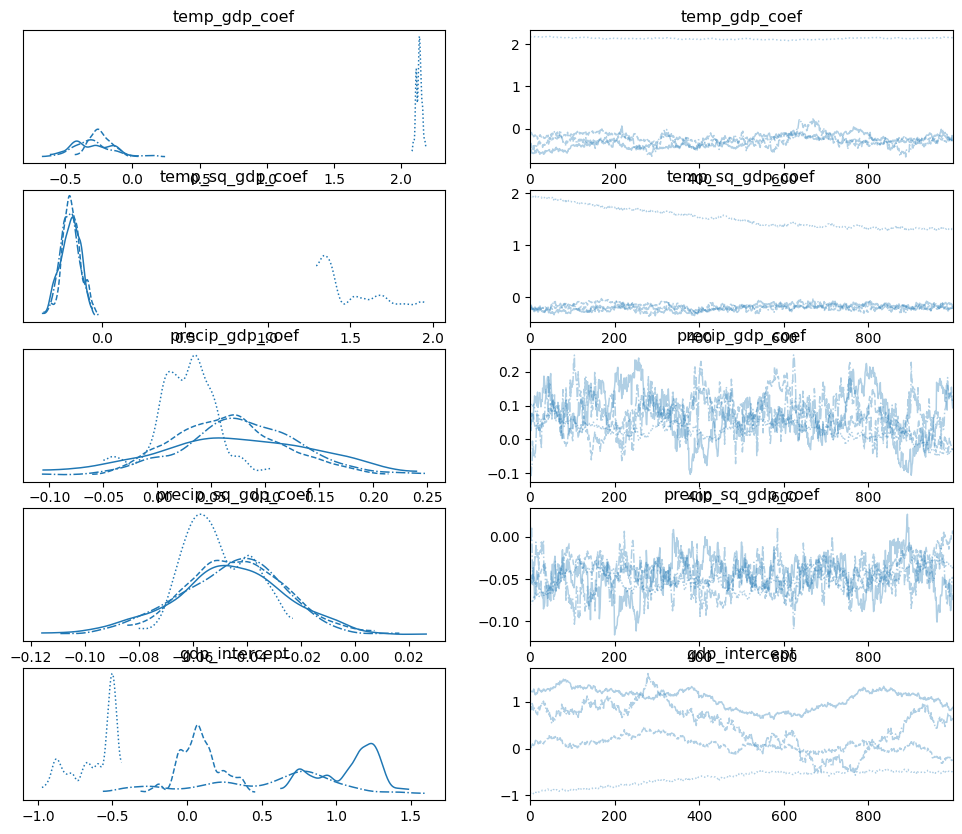

In [28]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"]).ravel()[0].figure
fig.show()

# Reproduce 13C threshold with probabilistic model

In [26]:
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
numerator = [val for val in coef1]
denominator = [-2*val for val in coef2]
res = temp_scaler.inverse_transform(np.array(numerator) / np.array(denominator).reshape(-1,1)).flatten()
# res = np.array(numerator) / np.array(denominator)
print(np.mean(res), np.mean(res) - np.std(res) * 1.645, np.mean(res) + np.std(res) * 1.645)

13.862714927141413 9.295515015520511 18.429914838762315


In [26]:
# where does the original 13C estimate fall?
zscore = (13.06 - np.mean(res)) / np.std(res)
print(zscore)

-0.161848262906849


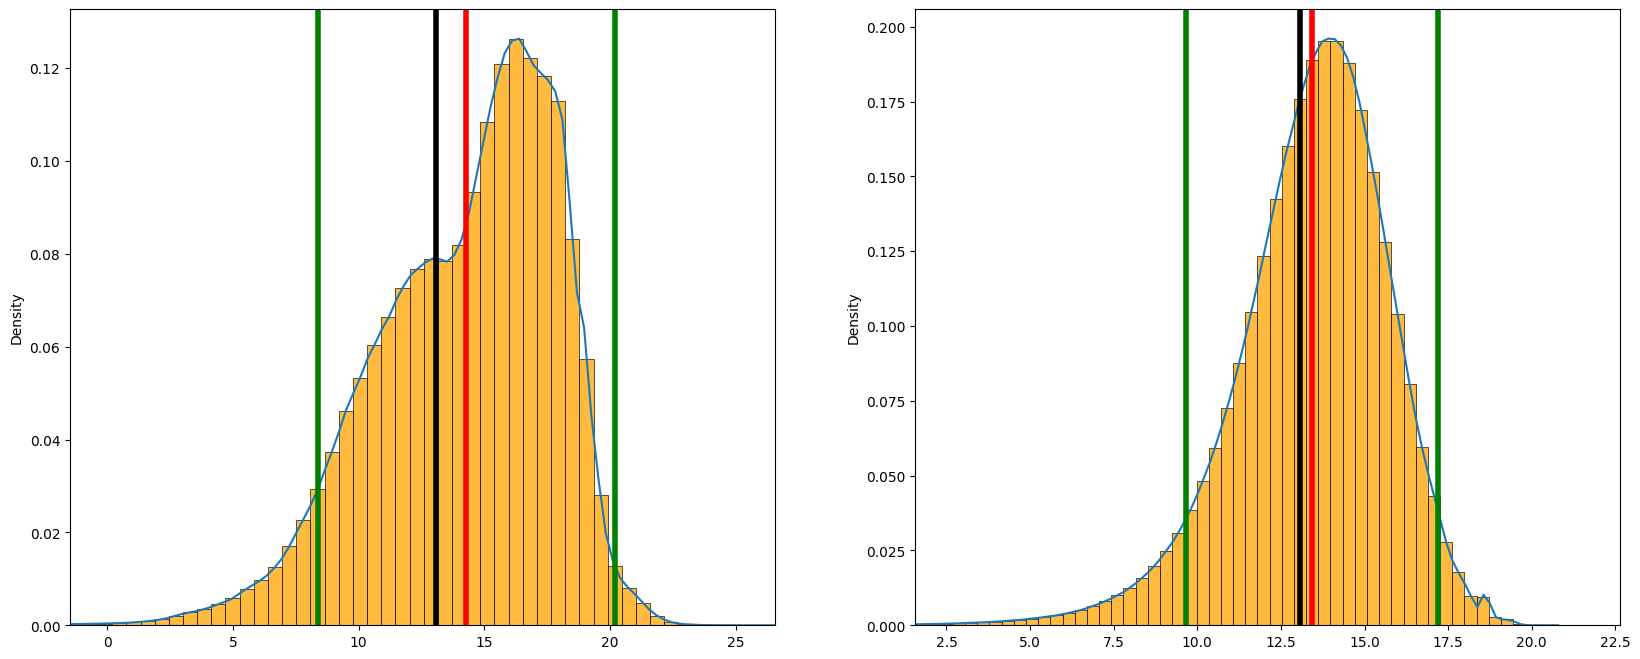

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

x = np.linspace(np.mean(res) - 3*np.std(res), np.mean(res) + 3*np.std(res), 100)
sns.histplot(res,bins=100,color="orange",stat="density", ax=ax1)
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res, ax=ax1)
ax1.axvline(x = np.mean(res), color = 'r', lw = 4, label = 'axvline - full height')
ax1.axvline(x = np.mean(res) - np.std(res) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax1.axvline(x = np.mean(res) + np.std(res) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax1.axvline(x = 13.06, color = 'k', lw = 4, label = 'axvline - full height')
ax1.set_xlim(min(x)-5, max(x)+1.5)

x = np.linspace(np.mean(res2) - 3*np.std(res2), np.mean(res) + 3*np.std(res2), 100)
sns.histplot(res2,bins=100,color="orange",stat="density", ax=ax2)
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res2, ax=ax2)
ax2.axvline(x = np.mean(res2), color = 'r', lw = 4, label = 'axvline - full height')
ax2.axvline(x = np.mean(res2) - np.std(res2) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax2.axvline(x = np.mean(res2) + np.std(res2) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax2.axvline(x = 13.06, color = 'k', lw = 4, label = 'axvline - full height')
ax2.set_xlim(min(x)-5, max(x)+1.5)

# plt.show()
plt.savefig("../figures/burke_reproduction_pdf.png")

# Scaled coefs for error estimation

In [11]:
print(np.mean(mult1*coef1))
print(np.std(mult1*coef1))
print(np.mean(mult2*coef2))
print(np.std(mult2*coef2))
print(np.mean(mult3*coef3))
print(np.std(mult3*coef3))
print(np.mean(mult4*coef4))
print(np.std(mult4*coef4))

0.0009992987682286047
0.0003539394893837055
-5.1253894660406745e-05
1.0137098523300436e-05
4.16911114081315e-06
5.192943994516138e-06
-3.784829953989272e-10
2.0221372426588823e-10


# Burke et al. Uncertainty Bounds

In [120]:
burke_temp_coef = .0127183
burke_temp2_coef = -.0004871
burke_temp_error = .0037876
burke_temp2_error = .0001184

lower_bound = (burke_temp_coef - burke_temp_error ) / (-2 * (burke_temp2_coef - burke_temp2_error))
upper_bound = (burke_temp_coef + burke_temp_error ) / (-2 * (burke_temp2_coef + burke_temp2_error))
mean = burke_temp_coef / (-2 * burke_temp2_coef)
print(lower_bound)
print(upper_bound)
print(mean)

7.374649050371593
22.383916463249253
13.05512215150893
